In [1]:
#load supplimentary packages
import os
import matplotlib.pyplot as plt
from copy import deepcopy

plt.rcParams['figure.dpi'] = 300  # For display in notebook

current_directory = os.getcwd()

In [2]:
#load cuurent experiment packages
from utils.utils import *
from utils.data_generation import *
from utils.constructors import *
from mgym.algorithms import *

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
#Setup factories
EnvFactory.constructors['ECSTR_S0'] = create_env_ECSTR_S0
ControlFactory.constructors['ECSTR_S0'] = create_pid_conrol_ECSTR_S0

EnvFactory.constructors['DistillationColumn'] = create_env_DistillationColumn
ControlFactory.constructors['DistillationColumn'] = create_pid_conrol_DistillationColumn

# ================ OFFLINE RL RESULTS==========================

In [4]:
#Show evaliation data graphics
def ECSTR_S0_show_data(algs_data):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(1, 5, 1)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["C"], label=alg_name)
    plt.ylim(0.8,1)
    
    plt.subplot(1, 5, 2)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["T"])
    plt.ylim(40,65)

    plt.subplot(1, 5, 3)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["h"])
    plt.ylim(0.6,0.8)

    plt.subplot(1, 5, 4)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["Tc"])
    plt.ylim(20,40)

    plt.subplot(1, 5, 5)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["q"])
    plt.ylim(0.0,0.2)

    plt.gca().legend([_ for _ in algs_data], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [5]:
#show target metricses
#Here we show metrics only for temperature (T) as the most indicative parameter.
def ECSTR_S0_metrics(metrics_calculators):
    for alg_name in metrics_calculators:
        _mc = metrics_calculators[alg_name]
        print(f"{alg_name}: ISF={_mc.ISF()[1]}; IAE={_mc.IAE()[1]}; ITAE={_mc.ITAE()[1]}; ITSH={_mc.ITSH()[1]};")

In [6]:
#run pretrained models on target scenario
def ECSTR_S0_assess_ofline(config, algs):
    config['normalize'] = False
    config['compute_diffs_on_reward'] = True

    control = ControlFactory.create(config=config)
    env_name = config["process_name"]
    location = "offline"
    logdir = os.path.join(os.path.join(os.path.join(".","pretrained"), f"{env_name}"),f"{location}")

    algorithms = []
    algorithms.append( (control, 'baseline', config['normalize'], ) )
    for alg_name in algs :
        algorithms.append( (RLModel(alg_name, logdir), alg_name, config['normalize'], ) )

    init_state = [0.1, 25, 0.1]
    setpoints  = [0.8778252, 51.34660837, 0.659]

    processes_data = {}
    metrics_calculators = {}
    for alg, alg_name, normalize in algorithms:
        _state = deepcopy(init_state)
        _env = EnvFactory.create(config=config)
        _env.reset(initial_state = init_state)
        processes_data[alg_name] = None
        metrics_calculators[alg_name] = MetricsCalculator(setpoints=setpoints, dt = 1)
        _mc = metrics_calculators[alg_name]

        iterations = 100
        _process_data = {"C":[], "T":[], "h":[], "Tc": [], "q":[]}
        for _ in range(iterations):
            _u = alg.predict(_state)
            _process_data["C"].append(_state[0])
            _process_data["T"].append(_state[1])
            _process_data["h"].append(_state[2])
            _process_data["Tc"].append(_u[0])
            _process_data["q"].append(_u[1])
            _mc.update(_state)

            _observation, _reward, _done, _info = _env.step(_u)
            _state = _observation
            
            processes_data[alg_name] = _process_data
            
    return processes_data, metrics_calculators

In [7]:
config = load_config_yaml(current_directory, 'ECSTR_S0')
processes_data, metrics_calculators = ECSTR_S0_assess_ofline(config=config, algs=[ 'COMBO'
                                                                          , 'MOPO'
                                                                          ,  'BC'
                                                                          , 'CQL'
                                                                          , 'PLAS'
                                                                          , 'PLASWithPerturbation'
                                                                          , 'BEAR'
                                                                          , 'SAC'
                                                                          , 'BCQ'
                                                                          , 'CRR'
                                                                          , 'AWAC'
                                                                          , 'DDPG'
                                                                          , 'TD3'
                                                           ])

2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=COMBO
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=MOPO
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=BC gamma=1.0 generated_maxlen=100000 n_steps=1 real_ratio=1.0 reward_scaler=None
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=CQL generated_maxlen=100000 real_ratio=1.0
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=PLAS generated_maxlen=100000 real_ratio=1.0
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=PLASWithPerturbation generated_maxlen=100000 real_ratio=1.0
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=BEAR generated_maxlen=100000 real_ratio=1.0
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=SAC generated_maxlen=100000 real_ratio=1.0
2025-10-16 11:56:06 [warning  ] Unused arguments are passed.   algorithm=BCQ generated_max

In [8]:
ECSTR_S0_metrics(metrics_calculators)

baseline: ISF=984.8772818387787; IAE=102.04416643382648; ITAE=1445.3205067483605; ITSH=8382.441826458062;
COMBO: ISF=491.73284994065983; IAE=51.69150978384751; ITAE=519.7109816521673; ITSH=1533.6073013849086;
MOPO: ISF=448.03463422232306; IAE=52.557417416924736; ITAE=1221.2198059554848; ITSH=1374.7274190567243;
BC: ISF=848.2762331165816; IAE=92.14834870666277; ITAE=1273.7882521999472; ITSH=6616.7404708061695;
CQL: ISF=1359.7134515132273; IAE=123.88980568077848; ITAE=1820.8165529106147; ITSH=13482.241546819205;
PLAS: ISF=905.558227726263; IAE=96.03469013912601; ITAE=1319.1512758487893; ITSH=7158.749179160248;
PLASWithPerturbation: ISF=763.0971737708174; IAE=83.416202567088; ITAE=1072.2413738031826; ITSH=5042.110722971581;
BEAR: ISF=16287.80550872824; IAE=491.7219114933244; ITAE=9475.497145626508; ITSH=253088.98468122905;
SAC: ISF=7247.776417762798; IAE=550.8872976697265; ITAE=32900.020462152424; ITSH=464381.41522206453;
BCQ: ISF=857.2442111574795; IAE=110.21896975056401; ITAE=2474.51437

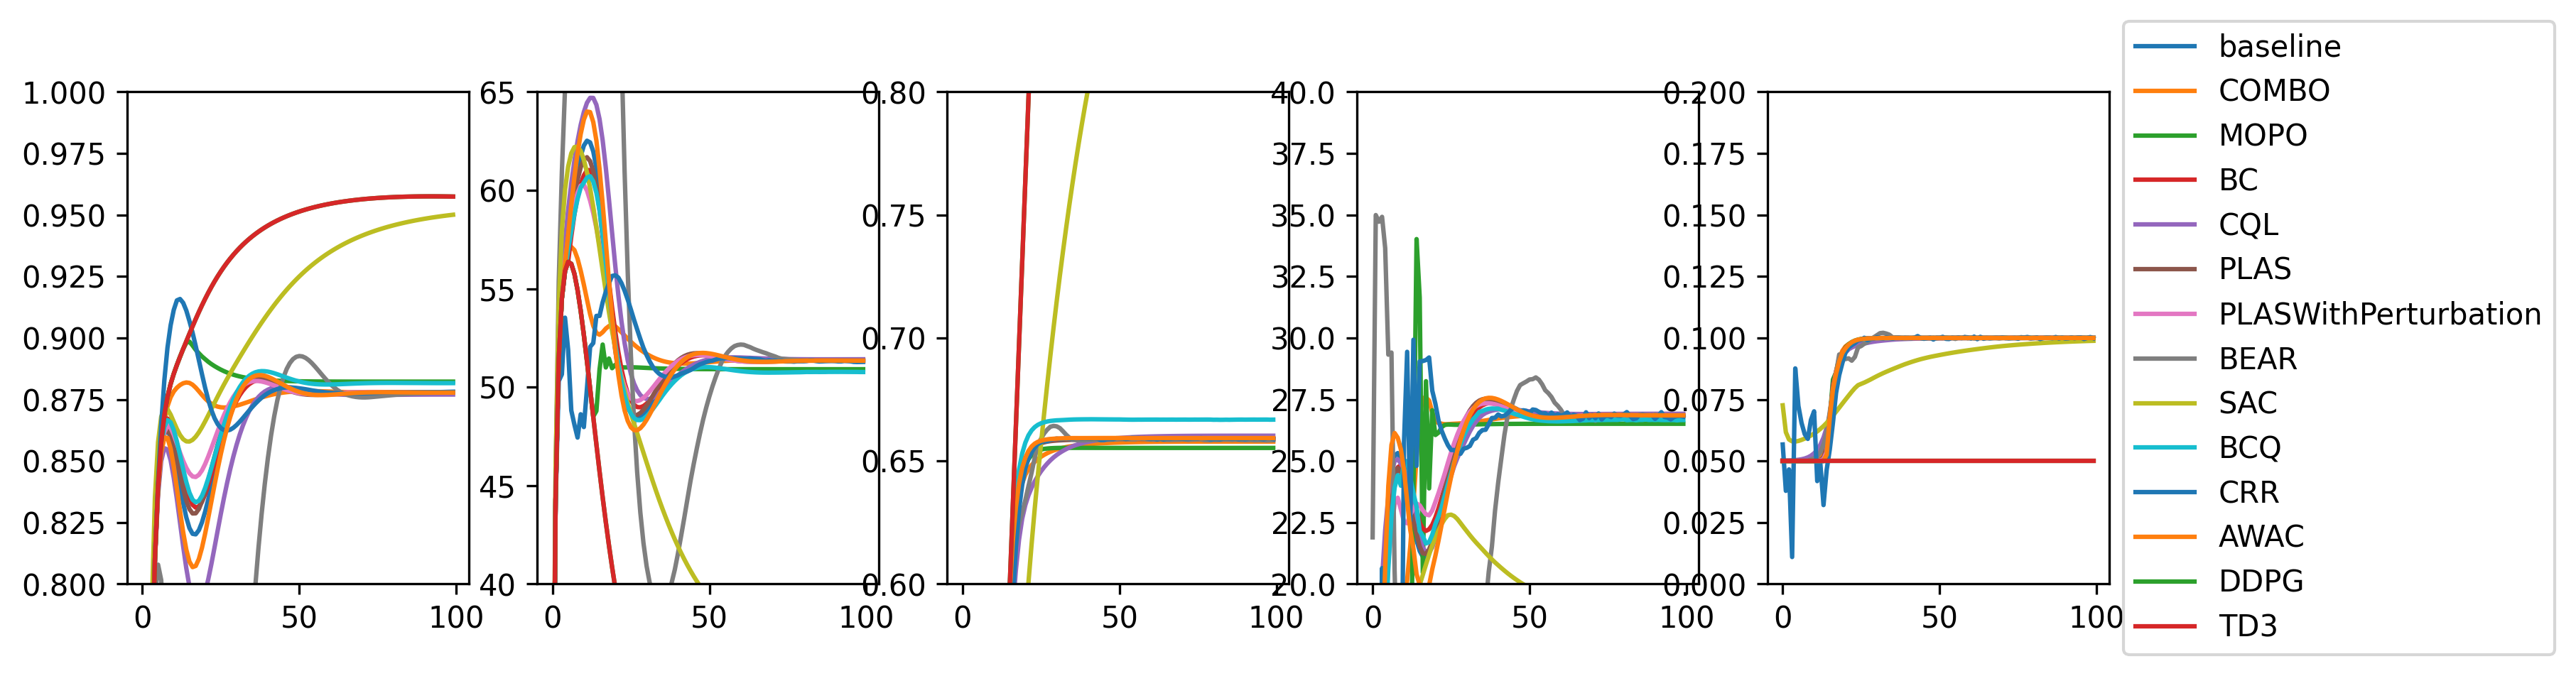

In [9]:
ECSTR_S0_show_data(processes_data)

In [10]:
#show only graphics with best performance

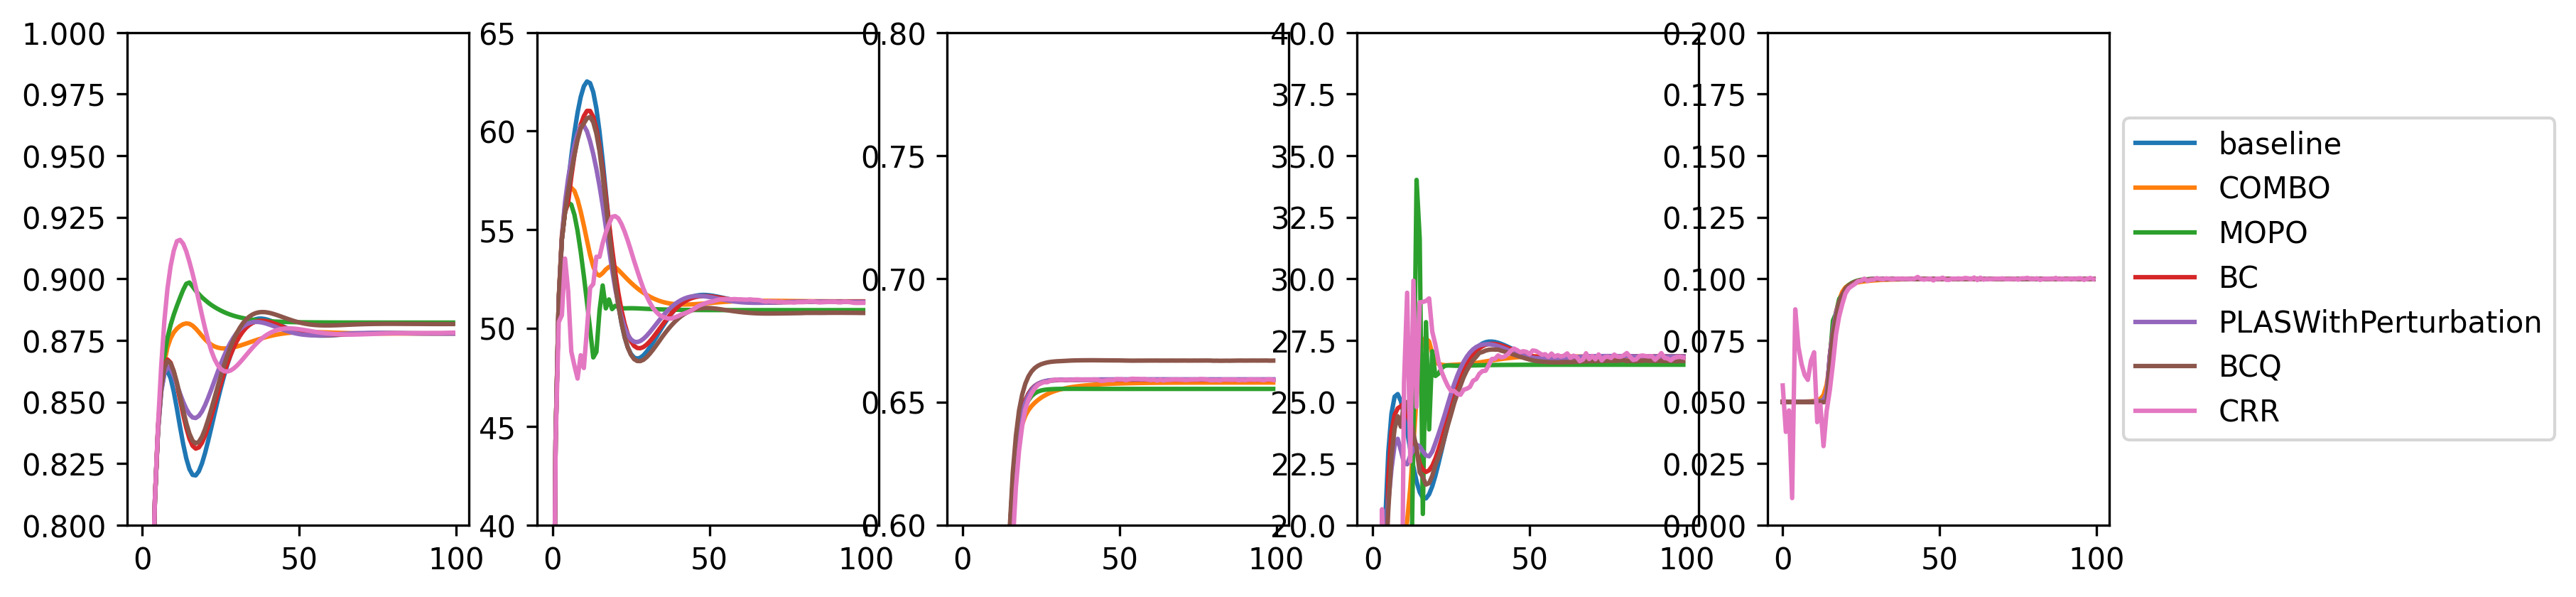

In [11]:
best_data = {}
for alg in ['baseline', 'COMBO', 'MOPO', 'BC', 'PLASWithPerturbation', 'BCQ', 'CRR',]:
    best_data[alg] = processes_data[alg]
ECSTR_S0_show_data(best_data)

# ================ ONLINE RL RESULTS==========================

In [12]:
import ray as ray 
from ray import tune
from ray.tune.registry import register_env
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLogger

In [13]:
AlgorithmsFactory.constructors["a2c"] = setup_alg_a2c
AlgorithmsFactory.constructors["a3c"] = setup_alg_a3c
AlgorithmsFactory.constructors["ars"] = setup_alg_ars
AlgorithmsFactory.constructors["ppo"] = setup_alg_ppo
AlgorithmsFactory.constructors["sac"] = setup_alg_sac
AlgorithmsFactory.constructors["impala"] = setup_alg_impala

In [14]:
env_name = 'ECSTR_S0'
config['normalize'] = True
config['compute_diffs_on_reward'] = False
logdir = os.path.join(os.path.join(os.path.join(current_directory,"pretrained"), f"{env_name}"),f"online")

In [15]:
def case_env_ECSTR_S0_ReactorEnv(algorithms, config, init_state = np.array([0.1, 25, 0.1],dtype=np.float32)):
    
    setpoints  = np.array([0.8778252, 51.34660837, 0.659],dtype=np.float32)
        
    processes_data = {}
    metrics_calculators = {}
    for alg, alg_name in algorithms:
        _state = deepcopy(init_state)
        _env = EnvFactory.create(config=config)
        _env.reset(initial_state = init_state)
        processes_data[alg_name] = None
        metrics_calculators[alg_name] = MetricsCalculator(setpoints=setpoints, dt = 1)
        _mc = metrics_calculators[alg_name]
            
        _state = _env.normalize_observations(_state)
        iterations = 100
        _process_data = {"C":[], "T":[], "h":[], "Tc": [], "q":[]}
        for _ in range(iterations):
            _u = alg.predict(_state)
            dn_u = _env.denormalize_actions(_u)
            dn_s = _env.denormalize_observations(_state)
            _mc.update(dn_s)

            _process_data["C"].append(dn_s[0])
            _process_data["T"].append(dn_s[1])
            _process_data["h"].append(dn_s[2])
            _process_data["Tc"].append(dn_u[0])
            _process_data["q"].append(dn_u[1])                
            processes_data[alg_name] = _process_data

            _observation, _reward, _done, _info = _env.step(_u)
            _state = _observation

    return processes_data, metrics_calculators

In [16]:
def ECSTR_S0_assess_ofline(config, algs, init_state = np.array([0.1, 25, 0.1],dtype=np.float32) ):
    processes_data = {}
    metrics_calculators = {}
    for alg_name in algs:
        try:
            rl_trainer, rl_config = AlgorithmsFactory.create(alg_name=alg_name,config = config)
            env_config = {
                "env_name": env_name,
                "normalize": config['normalize'],
                "dense_reward": config['dense_reward'],
                "compute_diffs_on_reward": config['compute_diffs_on_reward'],    
            }
            
            def env_creator(env_config):
                return create_env_ECSTR_S0(config)
                
            register_env("ECSTR_S0", env_creator)
             
            checkpoint_path = os.path.join(logdir,alg_name)
            checkpoint_path = os.path.join(checkpoint_path,'best')
            checkpoint_path = os.path.join(checkpoint_path,'best') 
            
            rl_config["env_config"] = env_config
            rl_config["framework"] = "torch"
            rl_config["evaluation_interval"] = int(config['train_iter'] / 10)
            agent = rl_trainer(rl_config, env=config['process_name'])
            agent.restore(checkpoint_path)
        
            algorithms=[]
            algorithms.append((RayAgentWrapper(agent=agent),alg_name,))
        
            _process_data, _metrics_calculators = case_env_ECSTR_S0_ReactorEnv(algorithms=algorithms, config=config, init_state = init_state)
        
            processes_data[alg_name] = _process_data[alg_name]
            metrics_calculators[alg_name] = _metrics_calculators[alg_name]
                
        except Exception as exception:
            print(f'{alg_name} exception: {exception}')
    
    return processes_data, metrics_calculators

In [17]:
def ECSTR_S0_baseline(config, init_state = np.array([0.1, 25, 0.1],dtype=np.float32)):    
    algorithms=[]
    algorithms.append((BaselineAlgorithmWraper(ControlFactory.create(config=config), env=EnvFactory.create(config=config)), 'baseline', ) )
    process_data, metrics_calculators = case_env_ECSTR_S0_ReactorEnv(algorithms=algorithms, config=config, init_state = init_state)
    return process_data, metrics_calculators

In [18]:
processes_data, metrics_calculators = ECSTR_S0_assess_ofline(config, algs = [ 'a2c'
                                                                            , 'a3c'
                                                                            , 'ars'
                                                                            , 'impala'
                                                                            , 'ppo'
                                                                            ,'sac'
                                                                            ], init_state = np.array([0.3, 25, 0.3],dtype=np.float32) )

2025-10-16 11:56:37,500	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265
(pid=56672) Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
(pid=56672) Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
(pid=56672) See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
(pid=60440) Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
(pid=60440) Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
(pid=60440) See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2025-10-16 11:56:48,607	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has 

In [19]:
baseline_data, baseline_calculators = ECSTR_S0_baseline(config = config, init_state = np.array([0.3, 25, 0.3],dtype=np.float32) )
processes_data['baseline'] = baseline_data['baseline']
metrics_calculators['baseline'] = baseline_calculators['baseline']

In [20]:
ECSTR_S0_metrics(metrics_calculators)

a2c: ISF=634.0338891496017; IAE=57.389862417713545; ITAE=1327.5347782189876; ITSH=1929.7516446098853;
a3c: ISF=935.0997310232812; IAE=145.26728173657898; ITAE=6971.89912503166; ITSH=22813.55371658852;
ars: ISF=792.9629098740462; IAE=109.88270708253422; ITAE=3142.0048823552756; ITSH=6826.350684147983;
impala: ISF=710.566352589122; IAE=91.52532325158943; ITAE=3225.906202800638; ITSH=6349.044510604845;
ppo: ISF=540.3722042313349; IAE=49.03443961292297; ITAE=877.1691426136288; ITSH=1102.861886333135;
sac: ISF=672.6863352055545; IAE=57.687232926489216; ITAE=803.7071990857723; ITSH=1683.2459669280593;
baseline: ISF=1300.1891156814875; IAE=112.0711194720425; ITAE=1139.228113120721; ITSH=7653.8007029631535;


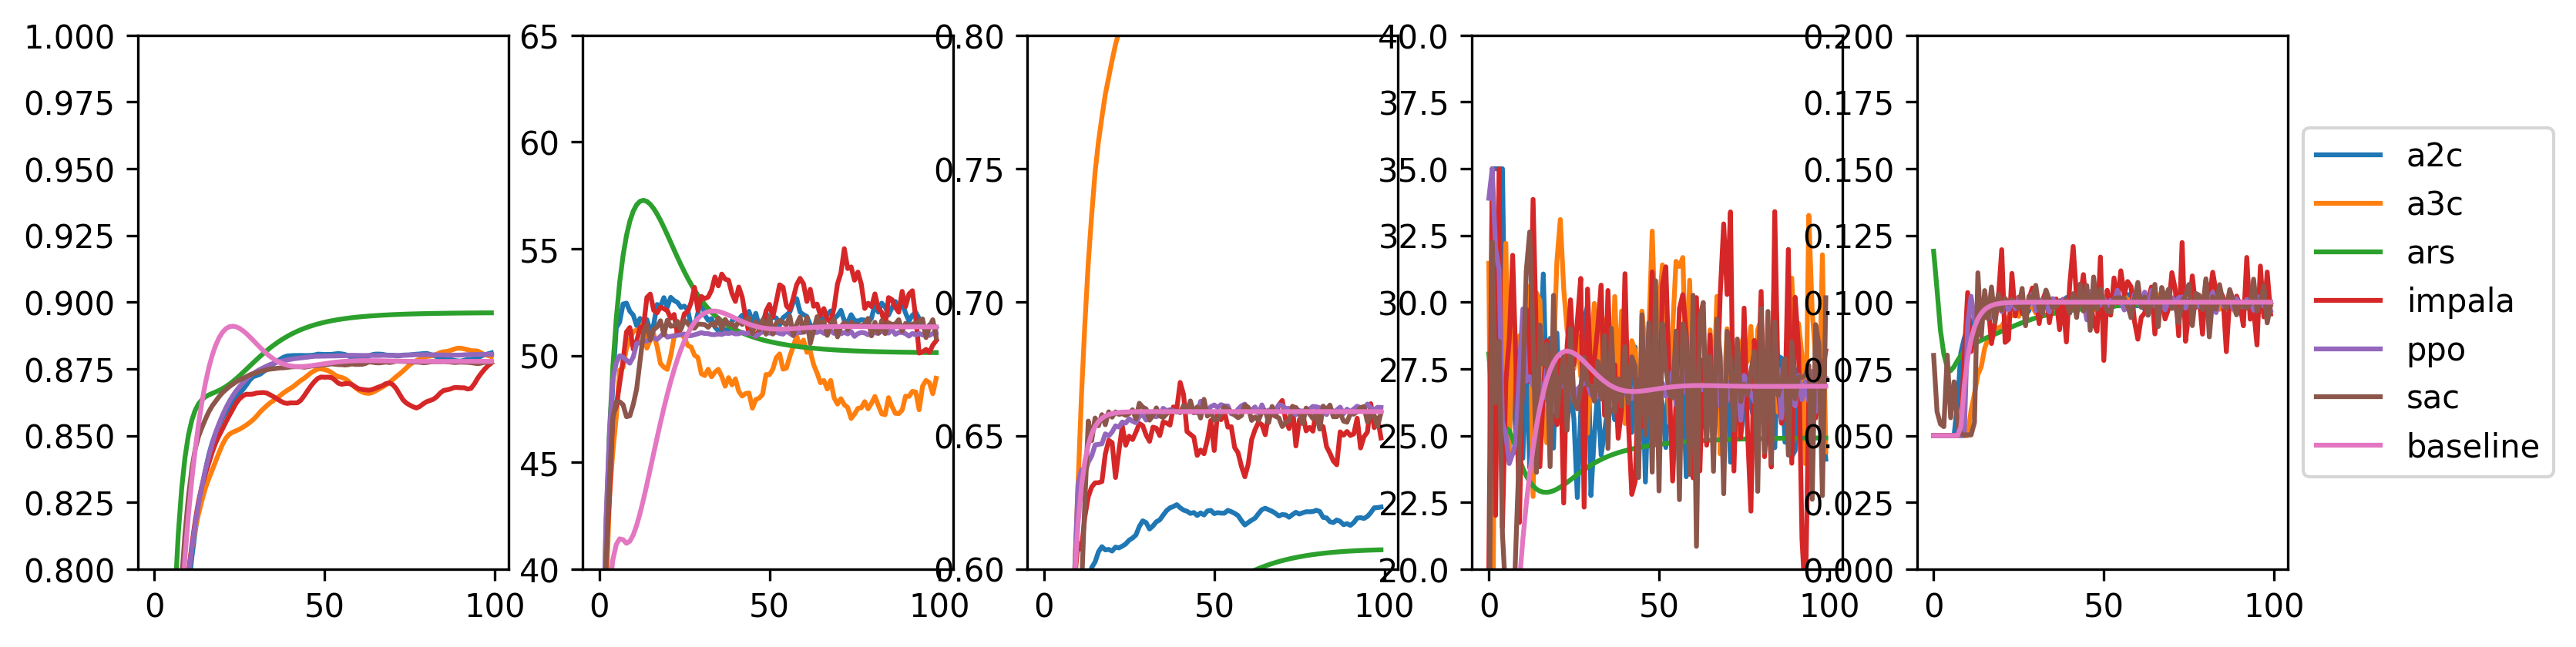

In [21]:
ECSTR_S0_show_data(processes_data)

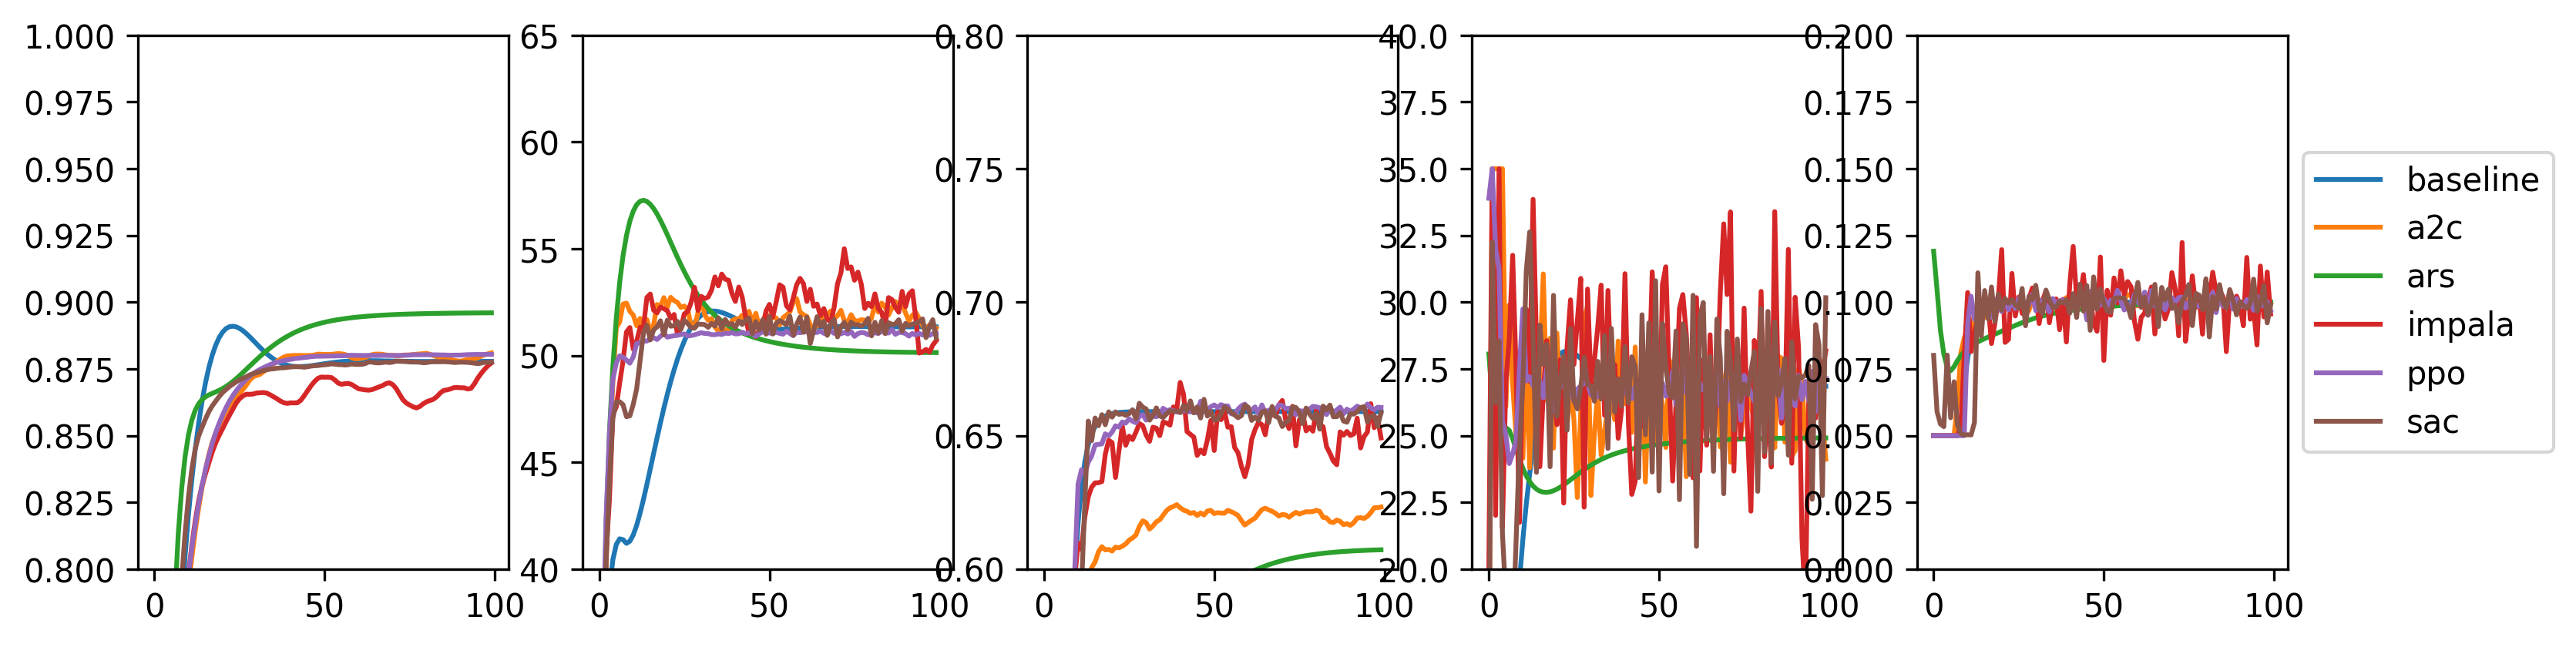

In [22]:
best_data = {}
for alg in ['baseline', 'a2c', 'ars', 'impala', 'ppo', 'sac',]:
    best_data[alg] = processes_data[alg]
ECSTR_S0_show_data(best_data)

In [ ]:
processes_data, metrics_calculators = ECSTR_S0_assess_ofline(config, algs = [ 'a2c'
                                                                            , 'a3c'
                                                                            , 'ars'
                                                                            , 'impala'
                                                                            , 'ppo'
                                                                            ,'sac'
                                                                            ], init_state = np.array([0.1, 25, 0.1],dtype=np.float32) )

In [24]:
baseline_data, baseline_calculators = ECSTR_S0_baseline(config = config, init_state = np.array([0.1, 25, 0.1],dtype=np.float32) )
processes_data['baseline'] = baseline_data['baseline']
metrics_calculators['baseline'] = baseline_calculators['baseline']

In [25]:
ECSTR_S0_metrics(metrics_calculators)

a2c: ISF=116115.75523606982; IAE=2392.6261103284132; ITAE=123603.00233413184; ITSH=6055794.700822361;
a3c: ISF=101919.82465573725; IAE=2175.966444225564; ITAE=120956.64151395262; ITSH=5853544.063440218;
ars: ISF=114591.64648971414; IAE=2355.396374670131; ITAE=123781.31366029367; ITSH=6091721.54588146;
impala: ISF=828.3831944584753; IAE=119.52925142039831; ITAE=4132.320130837908; ITSH=10681.276906991285;
ppo: ISF=528.1425197137767; IAE=58.05531472278513; ITAE=973.5177382220176; ITSH=1800.2782119808855;
sac: ISF=104707.46550765484; IAE=2258.9863580946335; ITAE=114336.79565403685; ITSH=5256979.770377952;
baseline: ISF=984.8773419442762; IAE=102.04417419540214; ITAE=1445.3210141284744; ITSH=8382.442344660347;
